# Transfer Learning

## Import Packages

In [1]:
# !pip uninstall ml_project_util -y
# !pip install git+https://github.com/aris-gk3/ml_project_util.git
# or for local development:
# %pip uninstall ml_project_util -y
%pip install git+https://github.com/aris-gk3/ml_project_util.git

import tensorflow as tf
import os
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
# Local Packages
from ml_project_util.path import path_definition
from ml_project_util.train import train, freeze_layers, unfreeze_head, unfreeze_block
from ml_project_util.quantization_util import quant_model, quant_bw_search
from ml_project_util.model_evaluation import model_evaluation_precise

  Cloning https://github.com/aris-gk3/ml_project_util.git to /tmp/pip-req-build-r75bjlzf
  Running command git clone --filter=blob:none --quiet https://github.com/aris-gk3/ml_project_util.git /tmp/pip-req-build-r75bjlzf
  Resolved https://github.com/aris-gk3/ml_project_util.git to commit 82d061a2b9b2f8c65f24c8244384153fc895ca61
  Preparing metadata (setup.py) ... done
  Created wheel for ml_project_util: filename=ml_project_util-0.1-py3-none-any.whl size=23769 sha256=80039022ab4bc58a338fe04e44cc40faf15d2e480938ae148d99ee2754a3f3df
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzqh4q8y/wheels/9b/33/7a/e8e8f55a4c6aa39df26369c48b9e3497c6dde4c7663912f8ef
Successfully built ml_project_util
Note: you may need to restart the kernel to use updated packages.


2025-06-23 10:57:26.081499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750676246.564183      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750676246.693441      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Variable Paths

In [2]:
dict = path_definition(ds_rel_path='stanford-dogs-restructured') # path_definition.config to read
BASE_PATH = dict['BASE_PATH']
PATH_DATASET = dict['PATH_DATASET']
PATH_TEST = dict['PATH_TEST']
PATH_RAWDATA = dict['PATH_RAWDATA']
PATH_JOINEDDATA = dict['PATH_JOINEDDATA']
PATH_SAVEDMODELS = dict['PATH_SAVEDMODELS']

ds_rel_path set to: stanford-dogs-restructured


## Load Model for PTQ & Evaluation

## Try PTQ & Evaluation (Evluate Correctness)

In [3]:
model_name = 'SD1_P2_FT2_008_val1.0290'
parent_name = model_name[:3]
model_path = '/kaggle/input/sd1_p2_ft/keras/default/1/SD1_P2_FT2_008_val1.0290.keras'
# model_path = f"{PATH_SAVEDMODELS}/{parent_name}/{model_name}.keras"
model = tf.keras.models.load_model(model_path)

I0000 00:00:1750676270.841269      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750676270.842068      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
model_evaluation_precise(model, mode='val')
model_evaluation_precise(model, mode='test')

Found 12397 files belonging to 120 classes.
Using 2479 files for validation.
Start evaluating batches
Batch Number: 0

I0000 00:00:1750676281.886600      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


Batch Number: 77
Precise val accuracy: 0.69746
Precise val loss: 1.02901
Found 8183 files belonging to 120 classes.
Start evaluating batches
Batch Number: 156
Precise test accuracy: 0.70880
Precise test loss: 1.08713


(0.70879775, 1.0871271600377312)

Quantizing model to 7 bits...
Saved json in: /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
Saved activation ranges in /kaggle/working/Docs_Reports/Quant/Ranges/SD1_P2_FT2_008_activation_range.json
Saved json in: /kaggle/working/Docs_Reports/Quant/Ranges/SD1_P2_FT2_008_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/SD1_P2_FT2_008_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 8183 files belonging to 120 classes.
Start evaluating batches


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Batch Number: 255
Precise test accuracy: 0.01955
Precise test loss: 4.77012
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/SD1_P2_FT2_008_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/SD1_P2_FT2_008_activation_range.json
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_2', 'dense_3']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1074.9937744140625}
HW next input range: 1494.113945603282


For layer 2.
Next input range: {'min': 0.0, 'max': 4313.04296875}
HW next input range: 5052.659349396766


For layer 3.
Next input range: {'min': 0.0, 'max': 7636.58984375}
HW next input range: 14603.064640715009


For layer 4.
Next input range: {'min': 0.0, 'max': 12

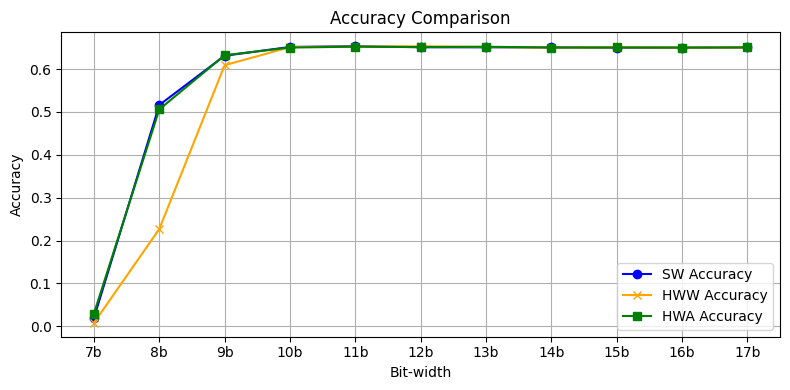

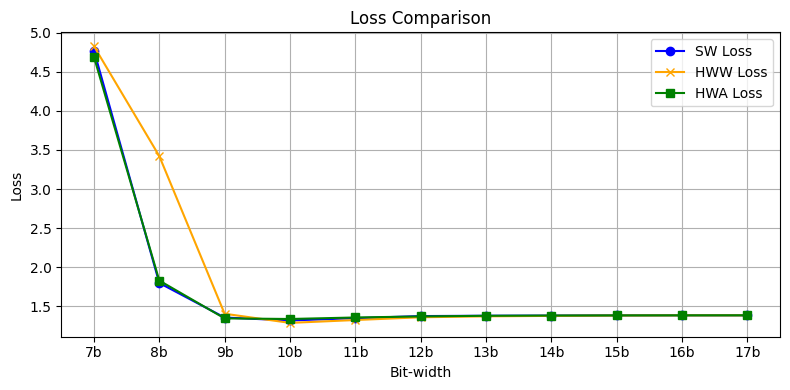

{
    "7b": {
        "accuracy": 0.01955273188650608,
        "loss": 4.770118484371204
    },
    "8b": {
        "accuracy": 0.5160698890686035,
        "loss": 1.7989477015468145
    },
    "9b": {
        "accuracy": 0.6309422254562378,
        "loss": 1.3574494229950358
    },
    "10b": {
        "accuracy": 0.6514725685119629,
        "loss": 1.3199312054672436
    },
    "11b": {
        "accuracy": 0.6533056497573853,
        "loss": 1.3494397137838983
    },
    "12b": {
        "accuracy": 0.6508615612983704,
        "loss": 1.3761568398984358
    },
    "13b": {
        "accuracy": 0.6506171226501465,
        "loss": 1.380435278883893
    },
    "14b": {
        "accuracy": 0.6506171226501465,
        "loss": 1.382345608331661
    },
    "15b": {
        "accuracy": 0.6498839259147644,
        "loss": 1.3853773400688265
    },
    "16b": {
        "accuracy": 0.6497616767883301,
        "loss": 1.3859609745176091
    },
    "17b": {
        "accuracy": 0.6503727436065674,


In [5]:
%%time
quant_bw_search(model, model_name, range(7,18))

---